## Element search
In this section we perform main elements search, such as switches and plugs.

https://arxiv.org/pdf/1703.10896.pdf

https://www.youtube.com/watch?v=zzcipxzZP9E



## Switch search

In [1]:
# Import libraries once
import numpy as np
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt

# Constant parameters used in Aruco methods
ARUCO_PARAMETERS = aruco.DetectorParameters_create()
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_5X5_50)

%run ../general-utility.ipynb # Useful function for image visualization
%run ../2-markers/aruco-function-definition.ipynb

In [4]:
debug = 1

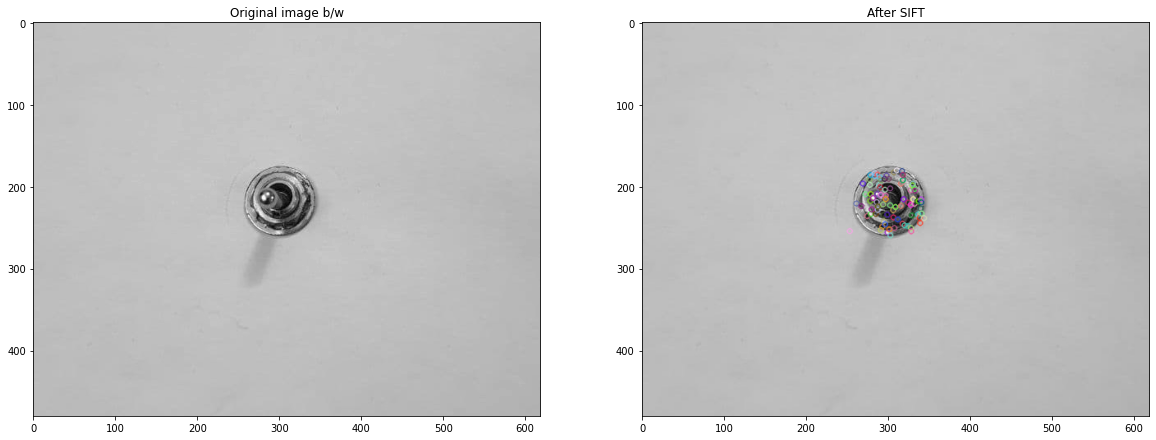

In [2]:
# Read the image with the markers
queryImg = cv2.imread("switches/switch_train_5.jpg")

# grayscale image
grayQueryImg = cv2.cvtColor(queryImg, cv2.COLOR_BGR2GRAY)

# create SIFT feature extractor
sift = cv2.xfeatures2d.SIFT_create()

# detect features from the image
keypoints_switch, descriptors_switch = sift.detectAndCompute(queryImg, None)

# draw the detected key points
sift_image = cv2.drawKeypoints(grayQueryImg, keypoints_switch, queryImg)
# show the image
show_two_imgs(grayQueryImg, "Original image b/w", sift_image, "After SIFT")

## Area definition
In order to better obtain descriptors and not analyze all the image, first we delimit the area of operation.

Found 1 markers.
Rect with angle: 91.70135460532612
Dims: [ 622 1280]


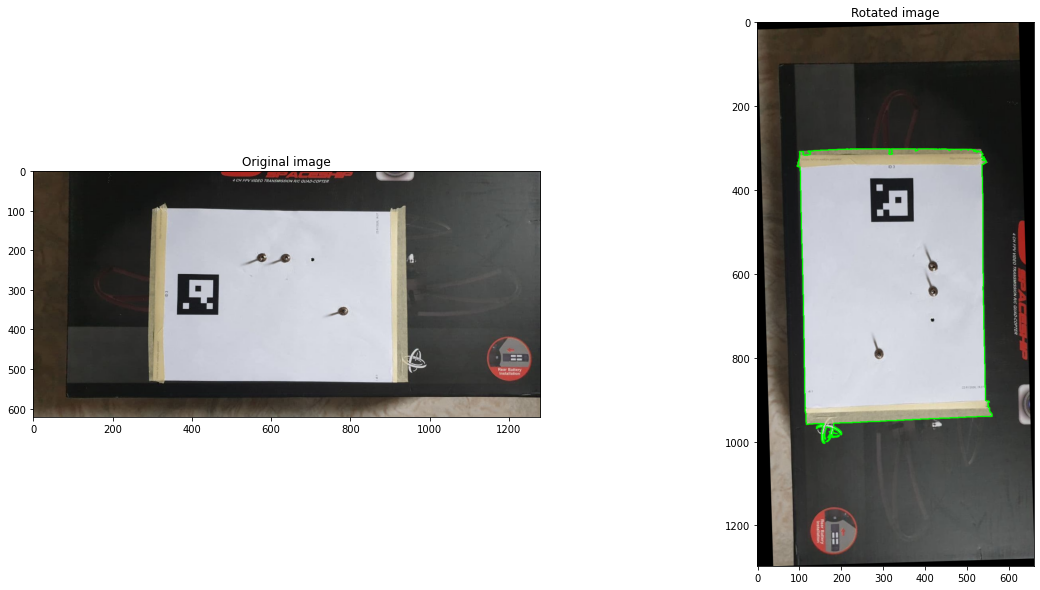

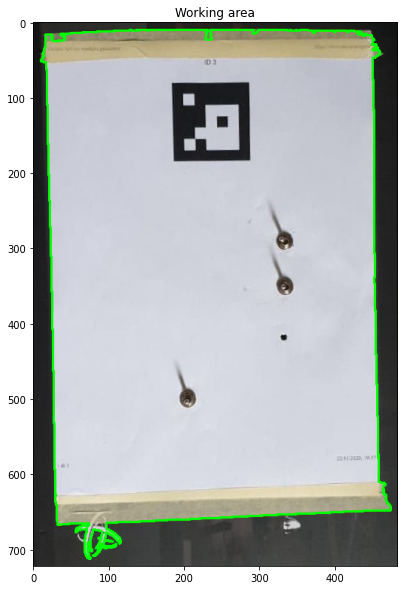

In [11]:
# Read the image and get all the aruco corners
panelImg, idsR, cornersR = findAruco("../2-markers/panel/panel-4.jpg", ARUCO_DICT, ARUCO_PARAMETERS)

grayPanelImg = cv2.cvtColor(panelImg, cv2.COLOR_BGR2GRAY)

markers_rects = findRectangles(panelImg, idsR, cornersR)
# markers_rects contains an array of contours for each aruco

cornersR = cornersR[0].astype(int)

if debug: print("Found {} markers.".format(len(idsR)))

#imgRectMin = np.copy(imgRect) # Only smallest one
min_contours = [] # store the min contour of each marker found in image
if len(markers_rects) > 0: 
    mrk = markers_rects[0] # consider only the first aruco
    areas = np.array(list(map(cv2.contourArea, mrk))) # compute the area of each contour
        
    min_area_n = np.argmin(areas) # find array num of the smallest area
    min_contours.append(mrk[min_area_n])
        
    # Get the orientation on the line as angle
    angle = np.arctan2(cornersR[0][0][1] - cornersR[0][1][1], cornersR[0][0][0] - cornersR[0][1][0]);
    if angle < 0:
        angle += 2 * np.pi
    angle_deg = angle * 180 / np.pi
    if debug: print("Rect with angle:", angle_deg)
    
    imgOriz = rotate_bound(panelImg, 180-angle_deg)
    imgOrizDraw = np.copy(imgOriz)
    if debug: print("Dims:", np.flip(panelImg.shape[1::-1]))
        
    corners_rotated, ids_rotated, _ = aruco.detectMarkers(imgOriz, ARUCO_DICT, parameters=ARUCO_PARAMETERS)
    markers_rects_rot = findRectangles(imgOriz, ids_rotated, corners_rotated)
    
    mrk_rot = markers_rects_rot[0] # consider only the first aruco
    areas_rot = np.array(list(map(cv2.contourArea, mrk_rot))) # compute the area of each contour
        
    min_area_n = np.argmin(areas) # find array num of the smallest area
    cv2.drawContours(imgOrizDraw, [mrk_rot[min_area_n]], -1, (0,255,0), 2)
    
    
    maxx, maxy = np.max(mrk_rot[min_area_n].reshape((mrk_rot[min_area_n].shape[0], 2)), axis=0) + 10
    minx, miny = np.min(mrk_rot[min_area_n].reshape((mrk_rot[min_area_n].shape[0], 2)), axis=0) - 10
    
    workingAreaImg = np.copy(imgOriz[miny:maxy,minx:maxx,:])
    #maxx, maxy = np.max(a, axis=0)
else:
    print("No containers found!")
    
show_two_imgs(panelImg, "Original image", imgOriz, "Rotated image")
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(imgOrizDraw, cv2.COLOR_BGR2RGB))
plt.title("Working area")
plt.show()

Not enough matches are found - 3/10


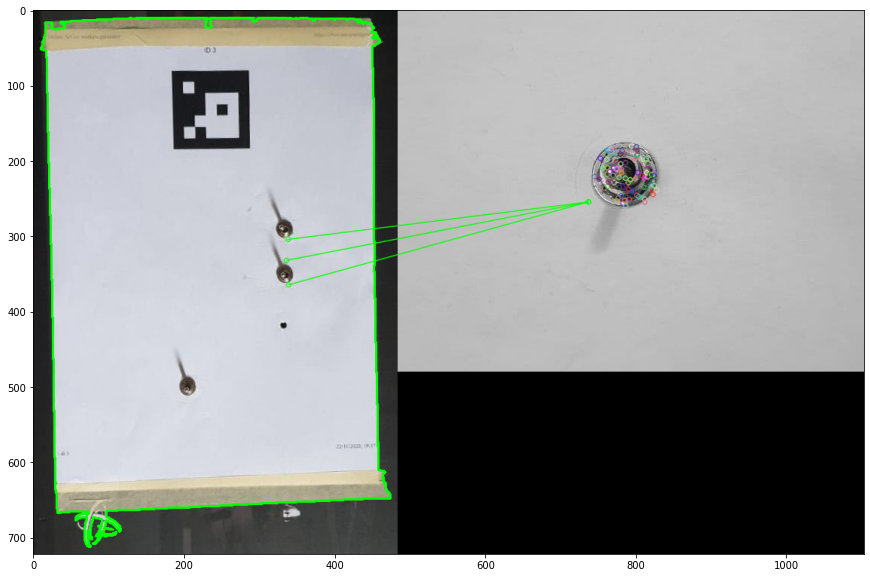

In [12]:
keypoints_panel, descriptors_panel = sift.detectAndCompute(workingAreaImg, None)

# Initializing the matching algorithm
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching the descriptors
matches = flann.knnMatch(descriptors_panel, descriptors_switch, k=2)

# Keeping only good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        
# If we have at least 10 matches we find the box of the object
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ keypoints_panel[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints_switch[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Matches mask for visualization of only matches used by RANSAC
    matchesMask = mask.ravel().tolist()

    # Apply homography to project corners of the query image into the image
    h,w = workingAreaImg.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    # Drawing bounding box
    grayQueryImg = cv2.polylines(grayQueryImg,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

# Drawing matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
SIFT_referenceImg = cv2.drawMatches(workingAreaImg, keypoints_panel, queryImg, keypoints_switch, good,None,**draw_params)

# Draw keypoints for debugging
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(SIFT_referenceImg, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# create feature matcher
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
# match descriptors of both images
matches = bf.match(descriptors_switch, descriptors_target)

# sort matches by distance
matches = sorted(matches, key = lambda x:x.distance)
# draw first 50 matches
matched_img = cv2.drawMatches(queryImg, keypoints_switch, panelImg, keypoints_target, matches[:50], panelImg, flags=2)


plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.title("Matches")
plt.show()